<a href="https://colab.research.google.com/github/amanjain487/tsai-eva6/blob/main/Assignments/S10/Resnet%20on%20Tiny%20ImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
# !unzip /content/tiny-imagenet-200.zip
print("Done")

Done


In [8]:
%rm -rf 'CIFAR_10'
!git clone https://github.com/amanjain487/CIFAR_10

Cloning into 'CIFAR_10'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (300/300), done.
remote: Compressing objects: 100% (288/288), done.
remote: Total 300 (delta 150), reused 16 (delta 6), pack-reused 0
Receiving objects: 100% (300/300), 69.35 KiB | 7.71 MiB/s, done.
Resolving deltas: 100% (150/150), done.


In [9]:
import sys
sys.path.append('/CIFAR_10/')

!pip install git+https://github.com/albumentations-team/albumentations.git


  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-5r1ydncl
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-5r1ydncl


In [10]:

from CIFAR_10 import tiny_imagenet_resnet18
from CIFAR_10 import utils
from CIFAR_10 import main
from CIFAR_10.GradCAM.visualize import VisualizeCam

!pip install torchsummary
from torchsummary import summary

import torch

In [11]:
device, best_acc, classes, net, criterion, optimizer, scheduler = main.define_model_utilities(model=tiny_imagenet_resnet18.ResNet18(), weight_decay=0, momentum=0.9, scheduler=None, loss="cross_entropy", optimizer_func="SGD", lr=0.01)

In [12]:
import time

import cv2
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset


# Giving each folder a ID
def get_id_dictionary(path):
    """This Function will genrate Id's for all classes
    Args:
        path (sting): file path to the classes txt file
    Returns:
        dict: key-class, value-Id
    """
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict


def get_data(path):
    """This function will create a list of file path to the image and their respective labels
    and will split them in training and testing samples
    Args:
        path (sting): file path to the classes txt file 
    Returns:
        list: training and testing images and labels 
    """
    id_dict = get_id_dictionary(path)
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()

    for key, value in id_dict.items():
        #train_data += [cv2.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)), cv2.COLOR_BGR2RGB) for i in range(500)]
        train_data += [path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)) for i in range(500)]
        train_labels += [value for i in range(500)]
    
    X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.3, random_state=42)
    print('finished loading data, in {} seconds'.format(time.time() - t))
    print('Samples for training: {}'.format(len(X_train)))
    print('Samples for testing: {}'.format(len(X_test)))

    return X_train, X_test, y_train, y_test

class ImagenetDataset(Dataset):
    """Pytoch class to generate data loaders for Tiny Image Net Dataset
    Args:
        Dataset (pytorch class):
    """
    def __init__(self, path, labels, transforms=None):
        """
        Args:
            path (list): list containing path of images 
            labels (list): respective labels for images 
            transforms (albumentations compose class, optional): Contains Image transformations to be applied. Defaults to None
        """
        self.transform = transforms
        self.path, self.labels = path, labels

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        """genrate data and label
        Args:
            idx (int): index of sample
        Returns:
            tensor: tansformed image and label
        """
        label = self.labels[idx]
        image = cv2.imread(self.path[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
          # Apply transformations
          image = self.transform(image=image)['image']
          #image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return image, label

    def get_class_to_id_dict(self, path, id_dict):
        """Create a dict of label to class 
        Args:
            path (string): file path to the classes txt file 
            id_dict (dict):  key-class, value-Id
        Returns:
            dict: get class of respective label
        """
        all_classes = {}
        result = {}
        for i, line in enumerate(open( path + 'words.txt', 'r')):
            n_id, word = line.split('\t')[:2]
            all_classes[n_id] = word

        for key, value in id_dict.items():
            result[value] = (key, all_classes[key])      
        return result     

In [13]:
path = '/content/tiny-imagenet-200/'
X_train, X_test, y_train, y_test = get_data(path)

starting loading data
finished loading data, in 0.12564802169799805 seconds
Samples for training: 70000
Samples for testing: 30000


In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean,std = (0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262)

train_transform = A.Compose([
  
  A.PadIfNeeded(min_height=76, min_width=76, always_apply=True),
  A.RandomCrop(64,64),
  A.Rotate(limit=15),
  A.CoarseDropout(1,24, 24, 1, 8, 8,fill_value=[m*255 for m in mean], mask_fill_value=None),
  A.VerticalFlip(),
  A.HorizontalFlip(),
  A.Normalize(mean, std),
  ToTensorV2()
])

test_transform = A.Compose([
  A.Normalize(mean, std),
  ToTensorV2()
])

train_loader = torch.utils.data.DataLoader(ImagenetDataset(X_train, y_train, train_transform) , batch_size=512,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(ImagenetDataset(X_test, y_test, test_transform), batch_size=512,
                                           shuffle=True, num_workers=1)

In [15]:
summary(net, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
         GroupNorm-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
         GroupNorm-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
         GroupNorm-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
         GroupNorm-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
        GroupNorm-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
        GroupNorm-14          [-1, 128,

In [16]:
train_loss, train_acc, test_loss, test_acc = main.start_training(50, net, criterion, optimizer, device, train_loader, test_loader, best_acc, scheduler)


Epoch: 1

Epoch: 1
Train Loss: 5.058 | Train Acc: 2.006% (1404/70000)
Test Loss: 4.975 | Test Acc: 2.583% (775/30000)

Epoch: 2

Epoch: 2
Train Loss: 4.702 | Train Acc: 5.130% (3591/70000)
Test Loss: 4.559 | Test Acc: 7.000% (2100/30000)

Epoch: 3

Epoch: 3
Train Loss: 4.348 | Train Acc: 9.026% (6318/70000)
Test Loss: 4.195 | Test Acc: 10.993% (3298/30000)

Epoch: 4

Epoch: 4
Train Loss: 4.084 | Train Acc: 12.660% (8862/70000)
Test Loss: 3.894 | Test Acc: 15.263% (4579/30000)

Epoch: 5

Epoch: 5
Train Loss: 3.879 | Train Acc: 15.356% (10749/70000)
Test Loss: 3.897 | Test Acc: 15.270% (4581/30000)

Epoch: 6

Epoch: 6
Train Loss: 3.698 | Train Acc: 18.344% (12841/70000)
Test Loss: 3.861 | Test Acc: 15.700% (4710/30000)

Epoch: 7

Epoch: 7
Train Loss: 3.571 | Train Acc: 20.094% (14066/70000)
Test Loss: 3.486 | Test Acc: 21.387% (6416/30000)

Epoch: 8

Epoch: 8
Train Loss: 3.418 | Train Acc: 22.701% (15891/70000)
Test Loss: 3.390 | Test Acc: 22.720% (6816/30000)

Epoch: 9

Epoch: 9
Train 

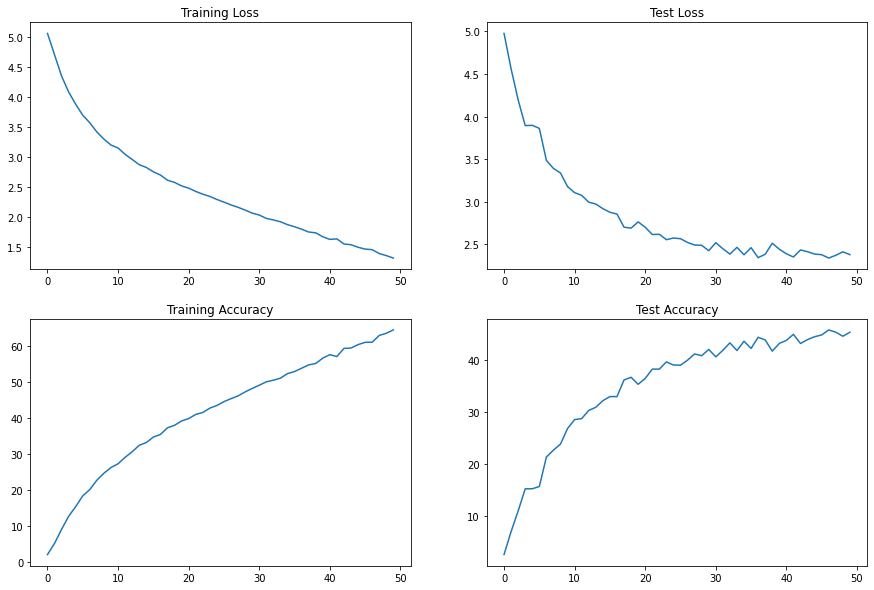

In [17]:
utils.plot_graph(train_loss, train_acc, test_loss, test_acc)
